In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
import matplotlib 
from rdkit import Chem
import math
import itertools
from rdkit import RDLogger
from sklearn.utils import shuffle
import pickle
RDLogger.DisableLog('rdApp.*') # ignore the rdkit warnings

def statistic_data(raw_data, verbose=True):
    records = dict()
    total_rxn = 0; total_context = 0
    for reaction_name, data in raw_data.items():
        t_rxn = len(set(data['Reaction ID']))
        t_context = len(data)
        records.update({reaction_name: [t_rxn, t_context]})
        total_rxn += t_rxn
        total_context += t_context
        if verbose:
            print(reaction_name, t_rxn, t_context)
    if verbose:
        print("Total reactions:", total_rxn)
        print("Total contexts:", total_context)
    return records

In [2]:
# Get the number of each reaction set
output_file_path = "../data/reaxys_output"
reaxys_dir = "../data/reaxys_input"
dir_names = ['Buchwald-HartwigCross-Coupling','Chan_LamCoupling','DielsAlder',
             'FischerIndoleSynthesis','Friedel-CraftsAcylation','Friedel-CraftsAlkylation',
             'GrignardReaction', 'KumadaCoupling', 'NegishiCoupling', 'ReductiveAmination'] # Change Here
os.makedirs(output_file_path, exist_ok=True)

def basic_preprocess(data_path):
    keep_index = ['Reaction ID', 'Reaction', 'Temperature (Reaction Details) [C]', 
                  'Yield (numerical)','Reagent', 'Solvent (Reaction Details)', 'Catalyst']
    data = pd.read_excel(data_path, engine="openpyxl")
    drop_index = list(data.columns)
    for index in list(data.columns):
        if index in keep_index:
            drop_index.remove(index)
    data = data.drop(drop_index,axis=1)
    data = data[:-3] # copyright or something 
    return data

# def reaction_entry(reaction_ids):
#     now = '0'
#     number = 0
#     for id_ in reaction_ids:
#         if id_ != now:
#             number += 1
#             now = id_
#     return number
            
records = dict()
raw_datas = dict()
    
file_path = os.path.join(reaxys_dir, dir_names[0])
a = os.listdir(file_path)
for dir_name in tqdm(dir_names):
    file_path = os.path.join(reaxys_dir, dir_name)
    for i, file_name in enumerate(os.listdir(file_path)):
        if not file_name.endswith(".xlsx"):
            continue
        data_path = os.path.join(file_path, file_name)
        if i == 0:
            reaction_set = basic_preprocess(data_path)
        else:
            data = basic_preprocess(data_path)
            reaction_set = reaction_set.append(data, ignore_index=True)
    
#     records.update({dir_name: [reaction_entry(reaction_set['Reaction ID']), len(reaction_set['Reaction ID'])]})
    raw_datas.update({dir_name : reaction_set})

print("--- Original reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/lungyi/anaconda3/envs/rxn_yield_context/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
100%|██████████| 10/10 [01:17<00:00,  7.74s/it]

--- Original reaction statistics: ---
Buchwald-HartwigCross-Coupling 26767 43862
Chan_LamCoupling 7170 10822
DielsAlder 19565 26590
FischerIndoleSynthesis 6869 8633
Friedel-CraftsAcylation 10476 25844
Friedel-CraftsAlkylation 17799 31396
GrignardReaction 14019 23628
KumadaCoupling 16808 21892
NegishiCoupling 11514 13521
ReductiveAmination 50668 58480
Total reactions: 181655
Total contexts: 264668


# Remove the same reactions within different reaction types

In [3]:
previous_reaction_id = set()
for reaction_name, data in raw_datas.items():
    indexNames = data[data['Reaction ID'].isin(previous_reaction_id)].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    raw_datas.update({reaction_name: data})
    previous_reaction_id.update(data['Reaction ID'])
    
print("--- Original reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

--- Original reaction statistics: ---
Buchwald-HartwigCross-Coupling 26767 43862
Chan_LamCoupling 7170 10822
DielsAlder 19564 26589
FischerIndoleSynthesis 6869 8633
Friedel-CraftsAcylation 10475 25840
Friedel-CraftsAlkylation 17669 29361
GrignardReaction 14007 23379
KumadaCoupling 16487 20854
NegishiCoupling 11185 12900
ReductiveAmination 50664 58476
Total reactions: 180857
Total contexts: 260716


# Remove nan entries

In [4]:
def string_average(l_):
    l_ = [float(x) for x in l_]
    return np.average(l_)

def highest_temperature(temp:str):
    if str(temp) == 'nan':
        return temp
    temp = str(temp)
    temps = temp.split('; ')
    temps = [string_average(x.split(' - ')) for x in temps]
    # temp = temp.split(' - ')
    temp = max(temps)
    return temp

def remove_invalid_smiles(data):
    rxn_id = list(data['Reaction ID'])
    start_ = 0
    result = []
    for i in range(len(rxn_id)):
        if rxn_id[i] != rxn_id[start_]:
            end_ = i
            result.append((start_, end_))
            start_ = end_
    rm_pair = []
    for a, b in result:
        if (Chem.MolFromSmiles(str(data['products'][a])) == None) or (Chem.MolFromSmiles(str(data['reactants'][a])) == None):
            rm_pair.append((a,b))
    if rm_pair:        
        rm_pair = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in rm_pair]))
        data.drop(rm_pair, inplace=True)
        data = data.reset_index(drop=True)
    
def CheckNaN(target):
    try:
        target = float(target)
    except:
        if target:
            return False
        else:
            return True
    return math.isnan(target)

def CheckYield(target):
    '''function for having yield report'''
    try:
        target = float(target)
    except:
        return True
    return math.isnan(target)

def remove_duplicated_records(records):
    return '; '.join(list(dict.fromkeys(records.split('; '))))

# Define a custom function to combine columns A and B
def combine_columns(row):
    reagent, catalyst = row["Reagent"], row["Catalyst"]
    reag_isnan = CheckNaN(reagent)
    cata_isnan = CheckNaN(catalyst)
    if reag_isnan and cata_isnan:
        return float("nan")
    elif (not reag_isnan) and cata_isnan:
        return reagent
    elif reag_isnan and (not cata_isnan):
        return catalyst
    else:
        return "; ".join([reagent, catalyst])

for reaction, data in tqdm(raw_datas.items()):
    # split reaction smiles to reactant and product and remove no smiles data
    data[['reactants', 'products']] = data['Reaction'].str.split('>>',expand=True)
    data = data.drop(['Reaction'], axis=1)
    # reactant
    indexNames = data[ [CheckNaN(data.iloc[i]['reactants']) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    # product
    indexNames = data[ [CheckNaN(data.iloc[i]['products']) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    # remove invalid SMILES
    remove_invalid_smiles(data)
    data = data.reset_index(drop=True)
    # Merge the reagent and catalyst columns
    # Apply the custom function to each row of the DataFrame
    data["Reagent"] = data.apply(combine_columns, axis=1)
    # remove the data without solvent record
    indexNames = data[ [CheckNaN(data.iloc[i]['Solvent (Reaction Details)']) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    # remove the data without yield record
    indexNames = data[ [CheckYield(data.iloc[i]['Yield (numerical)']) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    # temperature: pick the highest temperature in the stages,
    # (Because we train the ranking and regression using two separate dataset)
    data['Temperature (Reaction Details) [C]'] = [highest_temperature(t) for t in data['Temperature (Reaction Details) [C]']]
    
    # remove the duplicate solvent or reagent in the same context entry
    for i in range(len(data)):
        data.loc[i,'Solvent (Reaction Details)'] = remove_duplicated_records(str(data.loc[i,'Solvent (Reaction Details)']))
        data.loc[i,'Reagent'] = remove_duplicated_records(str(data.loc[i,'Reagent']))
    
    raw_datas.update({reaction: data})
    
print("\n--- After removing nan entries reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

100%|██████████| 10/10 [03:42<00:00, 22.22s/it]


--- After removing nan entries reaction statistics: ---
Buchwald-HartwigCross-Coupling 12788 23468
Chan_LamCoupling 4960 7143
DielsAlder 8900 10794
FischerIndoleSynthesis 1504 1808
Friedel-CraftsAcylation 5112 8597
Friedel-CraftsAlkylation 9617 15214
GrignardReaction 7852 11590
KumadaCoupling 8639 10598
NegishiCoupling 7802 8784
ReductiveAmination 15835 18066
Total reactions: 83009
Total contexts: 116062


In [5]:
from collections import Counter
def count(x):
    return len(x.split('; '))
for reaction, data in tqdm(raw_datas.items()):
    print(reaction)
    emt = []
    for e in data['Reagent']:
        if type(e) != str:
            continue
        emt.append(count(e))
    print(Counter(emt))

100%|██████████| 10/10 [00:00<00:00, 83.93it/s]

Buchwald-HartwigCross-Coupling
Counter({3: 13320, 2: 5509, 1: 3543, 4: 887, 5: 178, 6: 24, 7: 7})
Chan_LamCoupling
Counter({2: 3362, 3: 1972, 1: 1346, 4: 395, 5: 63, 6: 4, 7: 1})
DielsAlder
Counter({1: 8973, 2: 1348, 3: 347, 4: 120, 5: 6})
FischerIndoleSynthesis
Counter({1: 1498, 2: 244, 3: 47, 4: 19})
Friedel-CraftsAcylation
Counter({1: 7352, 2: 957, 3: 247, 4: 40, 7: 1})
Friedel-CraftsAlkylation
Counter({1: 11904, 2: 2801, 3: 409, 5: 35, 4: 34, 6: 30, 7: 1})
GrignardReaction
Counter({1: 7945, 2: 2419, 3: 971, 4: 206, 5: 45, 6: 4})
KumadaCoupling
Counter({1: 5713, 2: 3556, 3: 959, 4: 248, 5: 120, 6: 2})
NegishiCoupling
Counter({2: 2956, 1: 2657, 3: 1703, 4: 1062, 5: 347, 6: 50, 7: 8, 8: 1})
ReductiveAmination
Counter({2: 8407, 1: 7022, 3: 2225, 4: 365, 5: 46, 6: 1})


# Move some solvent name to reagent dictionary, and move some reagent name to solvent dictionary.

In [6]:
def GetFrequencyDict(datas):
    Dict = dict({'nan':0})
    for data in datas:
        if CheckNaN(data):
            Dict['nan'] += 1
            continue
#         data = RemoveDuplicate(data)
        for sub_data in data.split('; '):
            if sub_data in Dict.keys():
                Dict[sub_data] += 1
            else:
                Dict.update({sub_data:1})
    return Dict

all_data = pd.concat(raw_datas.values())
reagent_dict = GetFrequencyDict(all_data['Reagent'])
solvent_dict = GetFrequencyDict(all_data['Solvent (Reaction Details)'])
solvent_dict.pop('nan',None)

overlap = reagent_dict.keys() & solvent_dict.keys()
print("Number of duplicate reaction roles in both reagent and solvent:", len(overlap))
print(overlap)

# determine which the class it should be
for key, value in solvent_dict.copy().items():
    if reagent_dict.get(key):
        if value >= reagent_dict[key]:
            reagent_dict.pop(key, None)
        else:
            solvent_dict.pop(key, None)

for reaction, data in tqdm(raw_datas.items()):
    for i in range(len(data)):
        r_s = data.loc[i,'Reagent'].split('; ')
        s_s = data.loc[i,'Solvent (Reaction Details)'].split('; ')
        for r in r_s.copy():
            if r in solvent_dict.keys():
                r_s.remove(r)
                s_s.append(r)
        for s in s_s.copy():
            if s not in solvent_dict.keys():
                s_s.remove(s)
                r_s.append(s)
        if r_s == []:
            data.loc[i,'Reagent'] = 'nan'
        else:
            data.loc[i,'Reagent'] = '; '.join(r_s)
        if s_s == []:
            data.loc[i,'Solvent (Reaction Details)'] = 'nan'
        else:
            data.loc[i,'Solvent (Reaction Details)'] = '; '.join(s_s)


    indexNames = data[ [CheckNaN(data.iloc[i]['Solvent (Reaction Details)']) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    raw_datas.update({reaction:data})
    
for reaction, data in tqdm(raw_datas.items()):
    for i in range(len(data)):    
        data.loc[i,'Solvent (Reaction Details)'] = remove_duplicated_records(str(data.loc[i,'Solvent (Reaction Details)']))
        data.loc[i,'Reagent'] = remove_duplicated_records(str(data.loc[i,'Reagent']))
    raw_datas.update({reaction:data})
    
print("\n--- After updating reaction roles reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of duplicate reaction roles in both reagent and solvent: 93
{'sulfuric acid', 'N,N-dimethyl-formamide', 'formamide', 'pyridine', 'propan-1-ol', 'ethyl acetate', 'sulfolane', 'phosphoric acid', 'acetic acid', '1,2-dimethoxyethane', 'propionic acid', 'phosphate buffer', 'triethylamine', 'trifluorormethanesulfonic acid', 'methoxybenzene', 'carbon dioxide', 'bromobenzene', 'quinoline', 'pentan-3-one', 'tert-butyl methyl ether', '2,4-dichlorophenoxyacetic acid dimethylamine', '1-Methylpyrrolidine', 'dimethyl sulfoxide', 'water-d2', 'trimethyl orthoformate', 'N,N,N,N,N,N-hexamethylphosphoric triamide', 'decane', "1,1,1,3',3',3'-hexafluoro-propanol", 'cyclohexanone', 'butan-1-ol', 'phenol', 'alpha,alpha,alpha-trifluorotoluene', 'benzophenone', 'diethyl ether', 'ethylenediamine', 'chlorobenzene', 'dodecane', 'di-isopropyl ether', 'cyclohexenone', 'N,N-dimethyl-aniline', 'diethylene glycol dimethyl ether', 'methanesulfonic acid', '1-methyl-pyrrolidin-2-one', '1,2-dichloro-ethane', 'tetra

100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


--- After updating reaction roles reaction statistics: ---
Buchwald-HartwigCross-Coupling 12788 23445
Chan_LamCoupling 4956 7133
DielsAlder 8846 10731
FischerIndoleSynthesis 1287 1554
Friedel-CraftsAcylation 5088 8552
Friedel-CraftsAlkylation 9570 15114
GrignardReaction 7852 11585
KumadaCoupling 8638 10597
NegishiCoupling 7802 8781
ReductiveAmination 15795 18024
Total reactions: 82622
Total contexts: 115516


# Remove the reaction with solvent >= 3 or reagent number >= 4, data information:

In [7]:
def CheckSemicolon_count(target, count = 3):
    if (type(target) == float) and math.isnan(target):
        return False
    return target.count('; ')+1 >= count

all_number_data = 0
remove_number_data = 0
for reaction, data in raw_datas.items():
    all_number_data += len(data)
    indexNames = data[ [CheckSemicolon_count(str(data.iloc[i]['Solvent (Reaction Details)'])) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    remove_number_data += len(indexNames)
    
    indexNames = data[ [CheckSemicolon_count(str(data.iloc[i]['Reagent']), count = 4) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    remove_number_data += len(indexNames)

    raw_datas.update({reaction:data})

print("The percent of data being removed: {:.2f}%\n".format(remove_number_data / all_number_data * 100))
print("\n--- After removing solvent >= 3 or reagent >= 4 reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

The percent of data being removed: 5.37%


--- After removing solvent >= 3 or reagent >= 4 reaction statistics: ---
Buchwald-HartwigCross-Coupling 12233 22353
Chan_LamCoupling 4606 6637
DielsAlder 8604 10449
FischerIndoleSynthesis 1268 1528
Friedel-CraftsAcylation 5056 8480
Friedel-CraftsAlkylation 9472 14999
GrignardReaction 7508 10962
KumadaCoupling 8233 10017
NegishiCoupling 6212 6918
ReductiveAmination 14886 16975
Total reactions: 78078
Total contexts: 109318


# Remove duplicated reaction condition records.

In [9]:
for reaction, data in raw_datas.items():
    rxn_id = list(data['Reaction ID'])
    start_ = 0
    result = []
    memory = []
    indexNames = []
    for i in range(len(rxn_id)):
        if rxn_id[i] != rxn_id[start_]:
            start_ = i
            memory = [str(data.iloc[i]['Reagent'])+'+'+str(data.iloc[i]['Solvent (Reaction Details)'])]
        else:
            condition = str(data.iloc[i]['Reagent'])+'+'+str(data.iloc[i]['Solvent (Reaction Details)'])
            if condition not in memory:
                memory.append(condition)
            else:
                indexNames.append(i)

    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    raw_datas.update({reaction:data})
    
print("\n--- After removing duplicate entries reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)


--- After removing duplicate entries reaction statistics: ---
Buchwald-HartwigCross-Coupling 12233 20381
Chan_LamCoupling 4606 6233
DielsAlder 8604 9742
FischerIndoleSynthesis 1268 1414
Friedel-CraftsAcylation 5056 7405
Friedel-CraftsAlkylation 9472 14401
GrignardReaction 7508 9521
KumadaCoupling 8233 9606
NegishiCoupling 6212 6752
ReductiveAmination 14886 16259
Total reactions: 78078
Total contexts: 101714


# Observe the frequency dict of reagent & solvent, almost zero catalyst in Reaxys data:

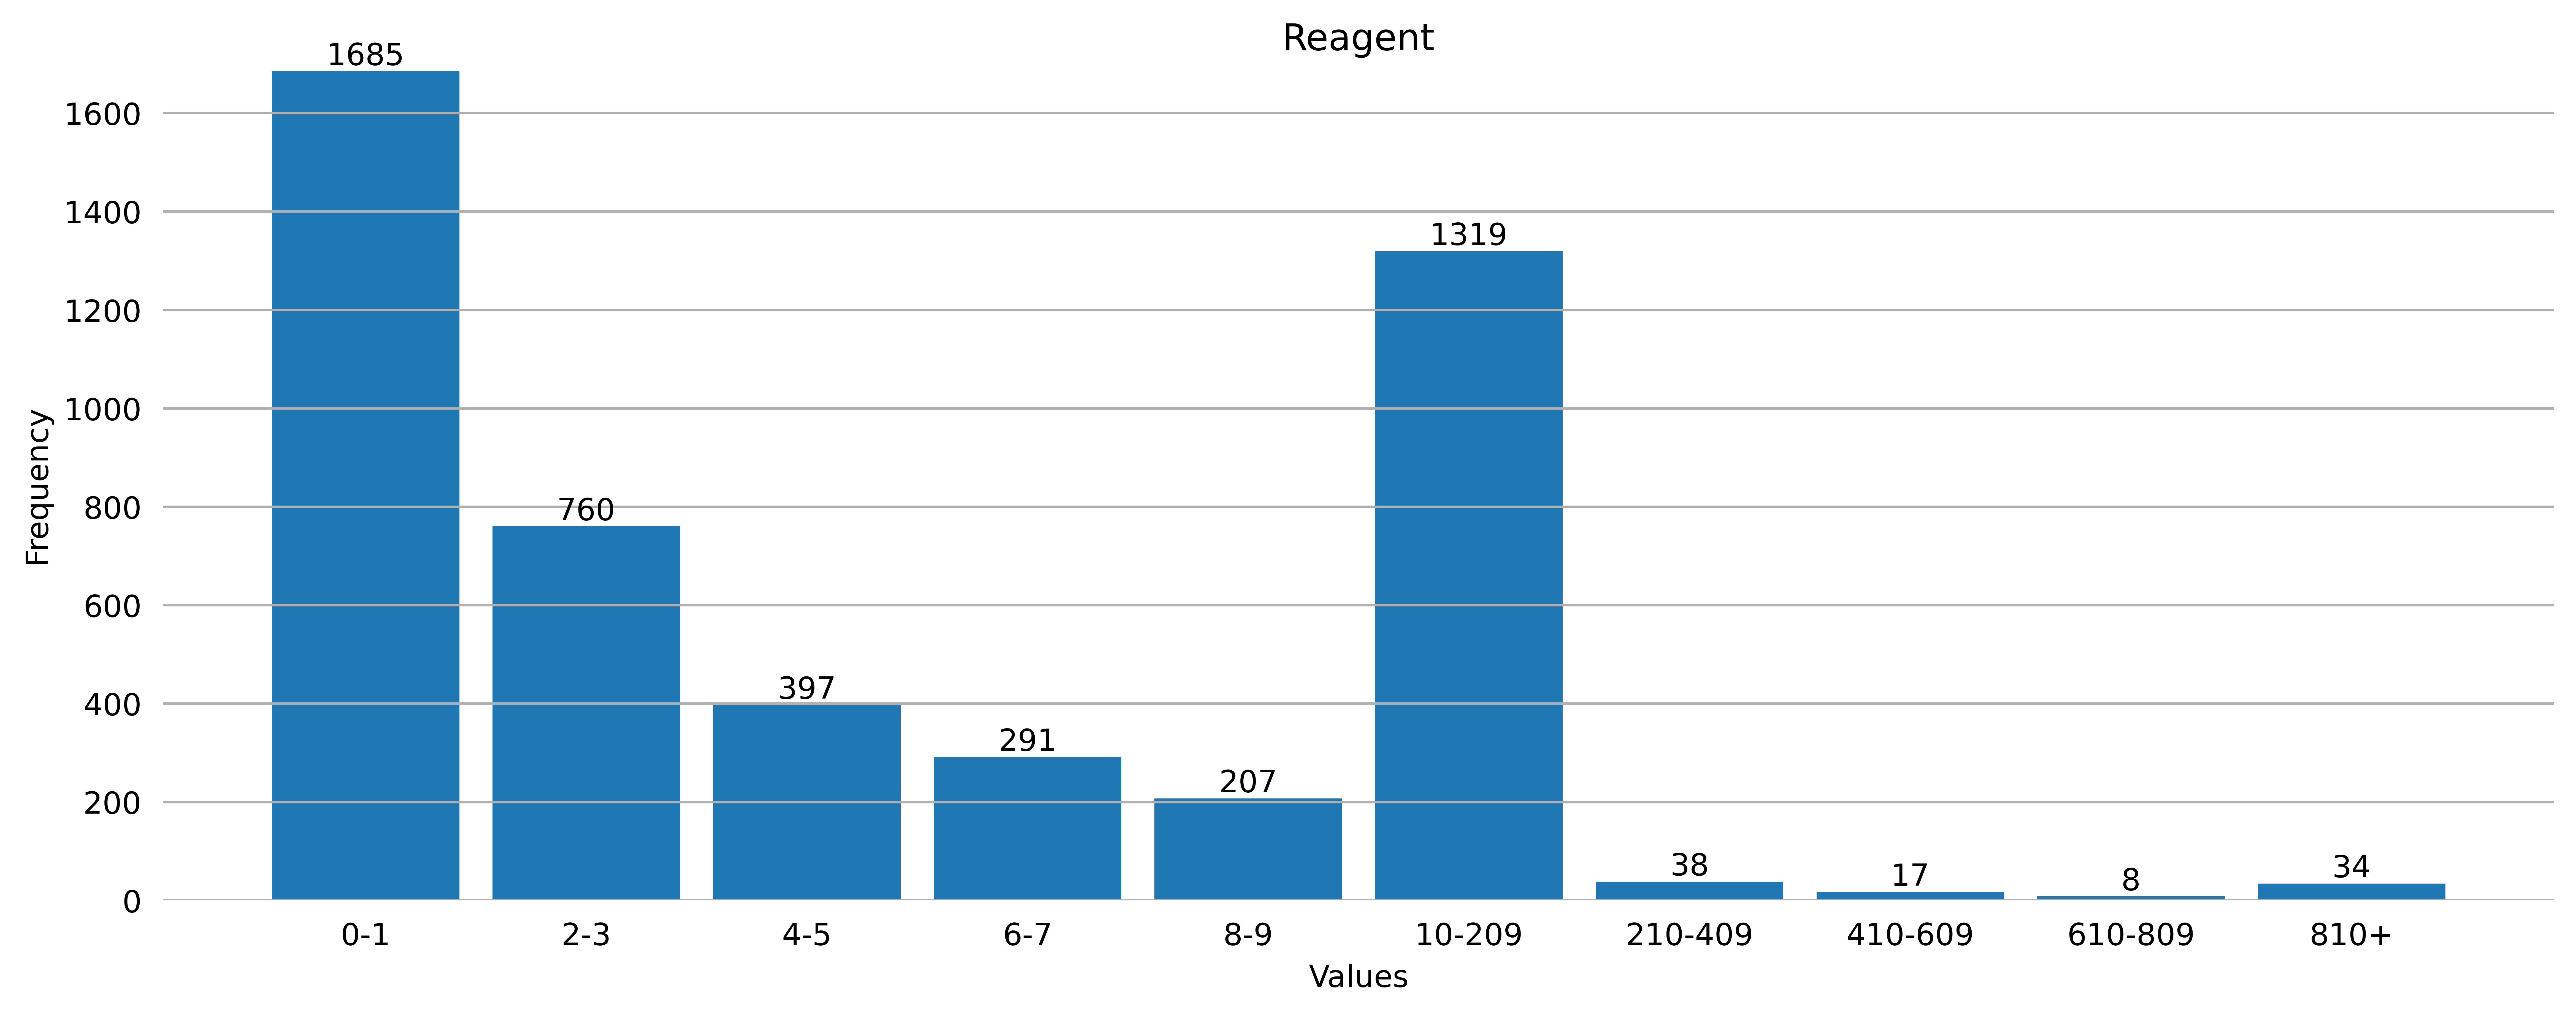

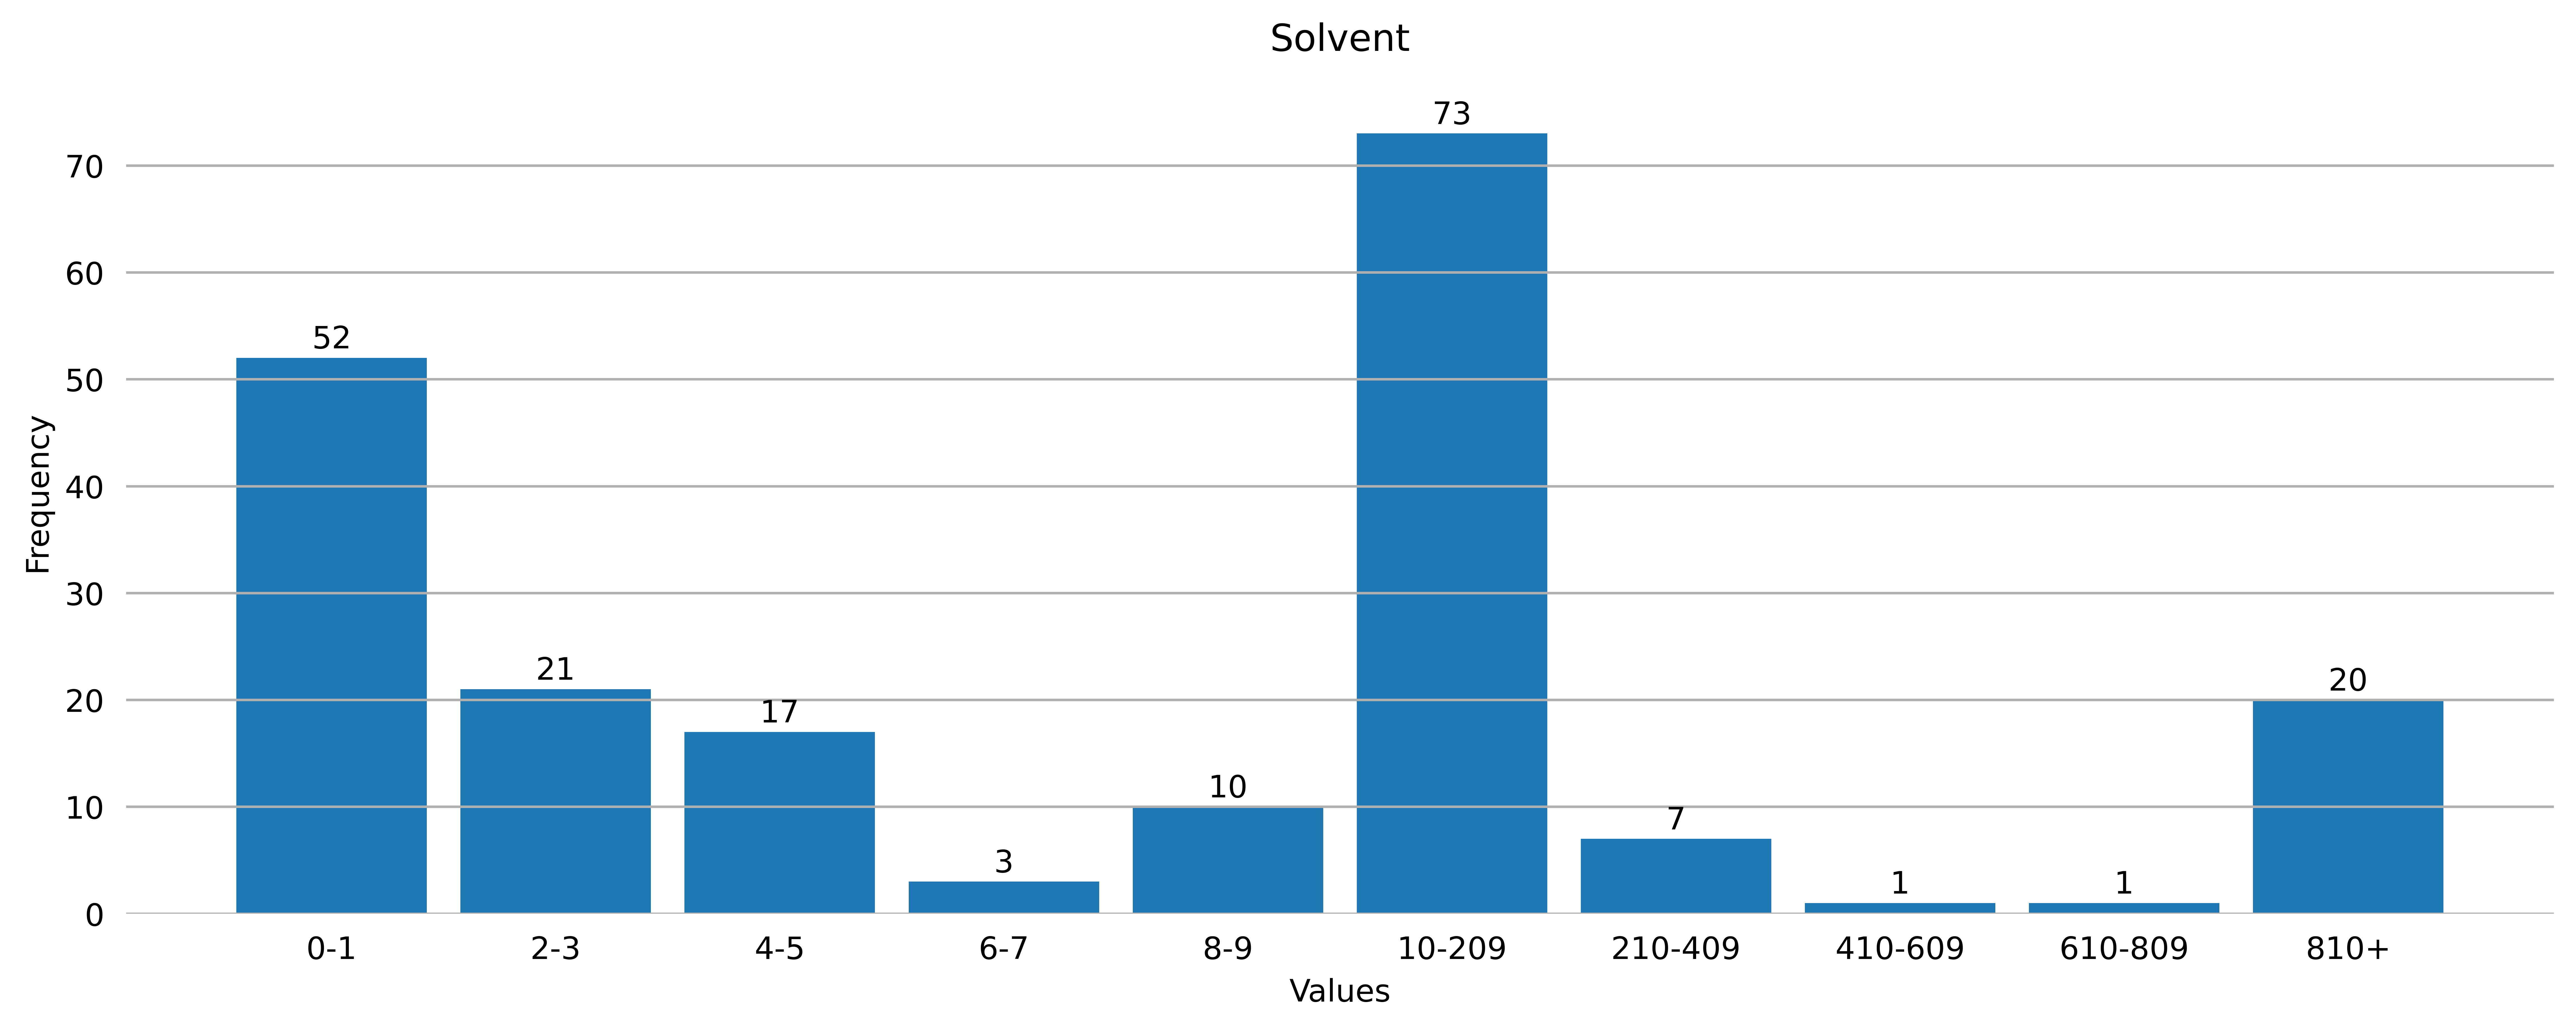

In [10]:
def RemoveDuplicate(target):
    target = list(set(target.split('; ')))
    return target

def GetFrequencyDict(datas):
    Dict = dict({'nan':0})
    for data in datas:
        if CheckNaN(data):
            Dict['nan'] += 1
            continue
        data = RemoveDuplicate(data)
        for sub_data in data:
            if sub_data in Dict.keys():
                Dict[sub_data] += 1
            else:
                Dict.update({sub_data:1})
    return Dict

def make_hist(ax, x, bins=None, binlabels=None, width=0.85, extra_x=1, extra_y=4, 
              text_offset=0.3, title=r"Frequency diagram", 
              xlabel="Values", ylabel="Frequency"):
    if bins is None:
        xmax = max(x)+extra_x
        bins = range(xmax+1)
    if binlabels is None:
        if np.issubdtype(np.asarray(x).dtype, np.integer):
            binlabels = [str(bins[i]) if bins[i+1]-bins[i] == 1 else 
                         '{}-{}'.format(bins[i], bins[i+1]-1)
                         for i in range(len(bins)-1)]
        else:
            binlabels = [str(bins[i]) if bins[i+1]-bins[i] == 1 else 
                         '{}-{}'.format(*bins[i:i+2])
                         for i in range(len(bins)-1)]
        if bins[-1] == np.inf:
            binlabels[-1] = '{}+'.format(bins[-2])
    n, bins = np.histogram(x, bins=bins)
    patches = ax.bar(range(len(n)), n, align='center', width=width)
    ymax = max(n)+extra_y

    ax.set_xticks(range(len(binlabels)))
    ax.set_xticklabels(binlabels)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, ymax)
    ax.grid(True, axis='y')
    # http://stackoverflow.com/a/28720127/190597 (peeol)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # http://stackoverflow.com/a/11417222/190597 (gcalmettes)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    autolabel(patches, text_offset)

def autolabel(rects, shift=0.3):
    """
    http://matplotlib.org/1.2.1/examples/pylab_examples/barchart_demo.html
    """
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            plt.text(rect.get_x()+rect.get_width()/2., height+shift, '%d'%int(height),
                     ha='center', va='bottom')

def plot_frequency(Dict:dict, title_name = 'Frequency Plot', save_path= None):
    x = list(Dict.values())
    fig, ax = plt.subplots(figsize=(14,5), dpi = 800)
    # make_hist(ax, x)
    # make_hist(ax, [1,1,1,0,0,0], extra_y=1, text_offset=0.1)
    make_hist(ax, x, bins=list(range(0,10,2))+list(range(10,1010,200))+[np.inf], extra_y=6, title= title_name)
    # plt.show()
    if save_path is not None:
        fig.savefig(save_path)

all_data = pd.concat(raw_datas.values())
reagent_dict = GetFrequencyDict(all_data['Reagent'])
plot_frequency(reagent_dict, 'Reagent', os.path.join(output_file_path, 'Reagent_plot_first.png'))
solvent_dict = GetFrequencyDict(all_data['Solvent (Reaction Details)'])
solvent_dict.pop('nan', None)
plot_frequency(solvent_dict, 'Solvent', os.path.join(output_file_path, 'Solvent_plot_first.png'))
# catalyst_dict = GetFrequencyDict(all_data['Catalyst'])
# plot_frequency(catalyst_dict, 'Catalyst')

# After observing the distribution of reagent and solvent data, now we remove data that uses reagent and solvent whose frequency < 10.

In [11]:
def get_remove_list(Dict:dict, freq:int):
    rm = [key for key, value in Dict.items() if value < freq ]
    return rm
def check_rm(reag:str, rm:list):
    if str(reag) == 'nan':
        return False
    reag = reag.split('; ')
    for x in reag:
        if x in rm:
            return True
    return False

rm_reagent = get_remove_list(reagent_dict, 10)
rm_solvent = get_remove_list(solvent_dict, 10)

for reaction, data in raw_datas.items():
    indexNames = data[ [check_rm(data.iloc[i]['Reagent'], rm_reagent) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    indexNames = data[ [check_rm(data.iloc[i]['Solvent (Reaction Details)'], rm_solvent) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    
    raw_datas.update({reaction:data})
'''
second remove < 5
'''
all_data = pd.concat(raw_datas.values())
reagent_dict = GetFrequencyDict(all_data['Reagent'])
solvent_dict = GetFrequencyDict(all_data['Solvent (Reaction Details)'])
solvent_dict.pop('nan', None)
rm_reagent = get_remove_list(reagent_dict, 5)
rm_solvent = get_remove_list(solvent_dict, 5)

for reaction, data in raw_datas.items():
    indexNames = data[ [check_rm(data.iloc[i]['Reagent'], rm_reagent) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    indexNames = data[ [check_rm(data.iloc[i]['Solvent (Reaction Details)'], rm_solvent) for i in range(len(data))] ].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    
    raw_datas.update({reaction:data})

print("\n--- After removing the entries using rare (<10) condition labels reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)


--- After removing the entries using rare (<10) condition labels reaction statistics: ---
Buchwald-HartwigCross-Coupling 11790 18518
Chan_LamCoupling 4556 5770
DielsAlder 7923 8601
FischerIndoleSynthesis 1229 1354
Friedel-CraftsAcylation 4905 6824
Friedel-CraftsAlkylation 8835 12530
GrignardReaction 7335 8896
KumadaCoupling 7762 8753
NegishiCoupling 5898 6371
ReductiveAmination 14444 15464
Total reactions: 74677
Total contexts: 93081


After removing data with frequency < 10: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93081 entries, 0 to 15463
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Reaction ID                         93081 non-null  object 
 1   Temperature (Reaction Details) [C]  79683 non-null  float64
 2   Yield (numerical)                   93081 non-null  object 
 3   Reagent                             93081 non-null  object 
 4   Catalyst                            1298 non-null   object 
 5   Solvent (Reaction Details)          93081 non-null  object 
 6   reactants                           93081 non-null  object 
 7   products                            93081 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.4+ MB
--------------------------------------------------



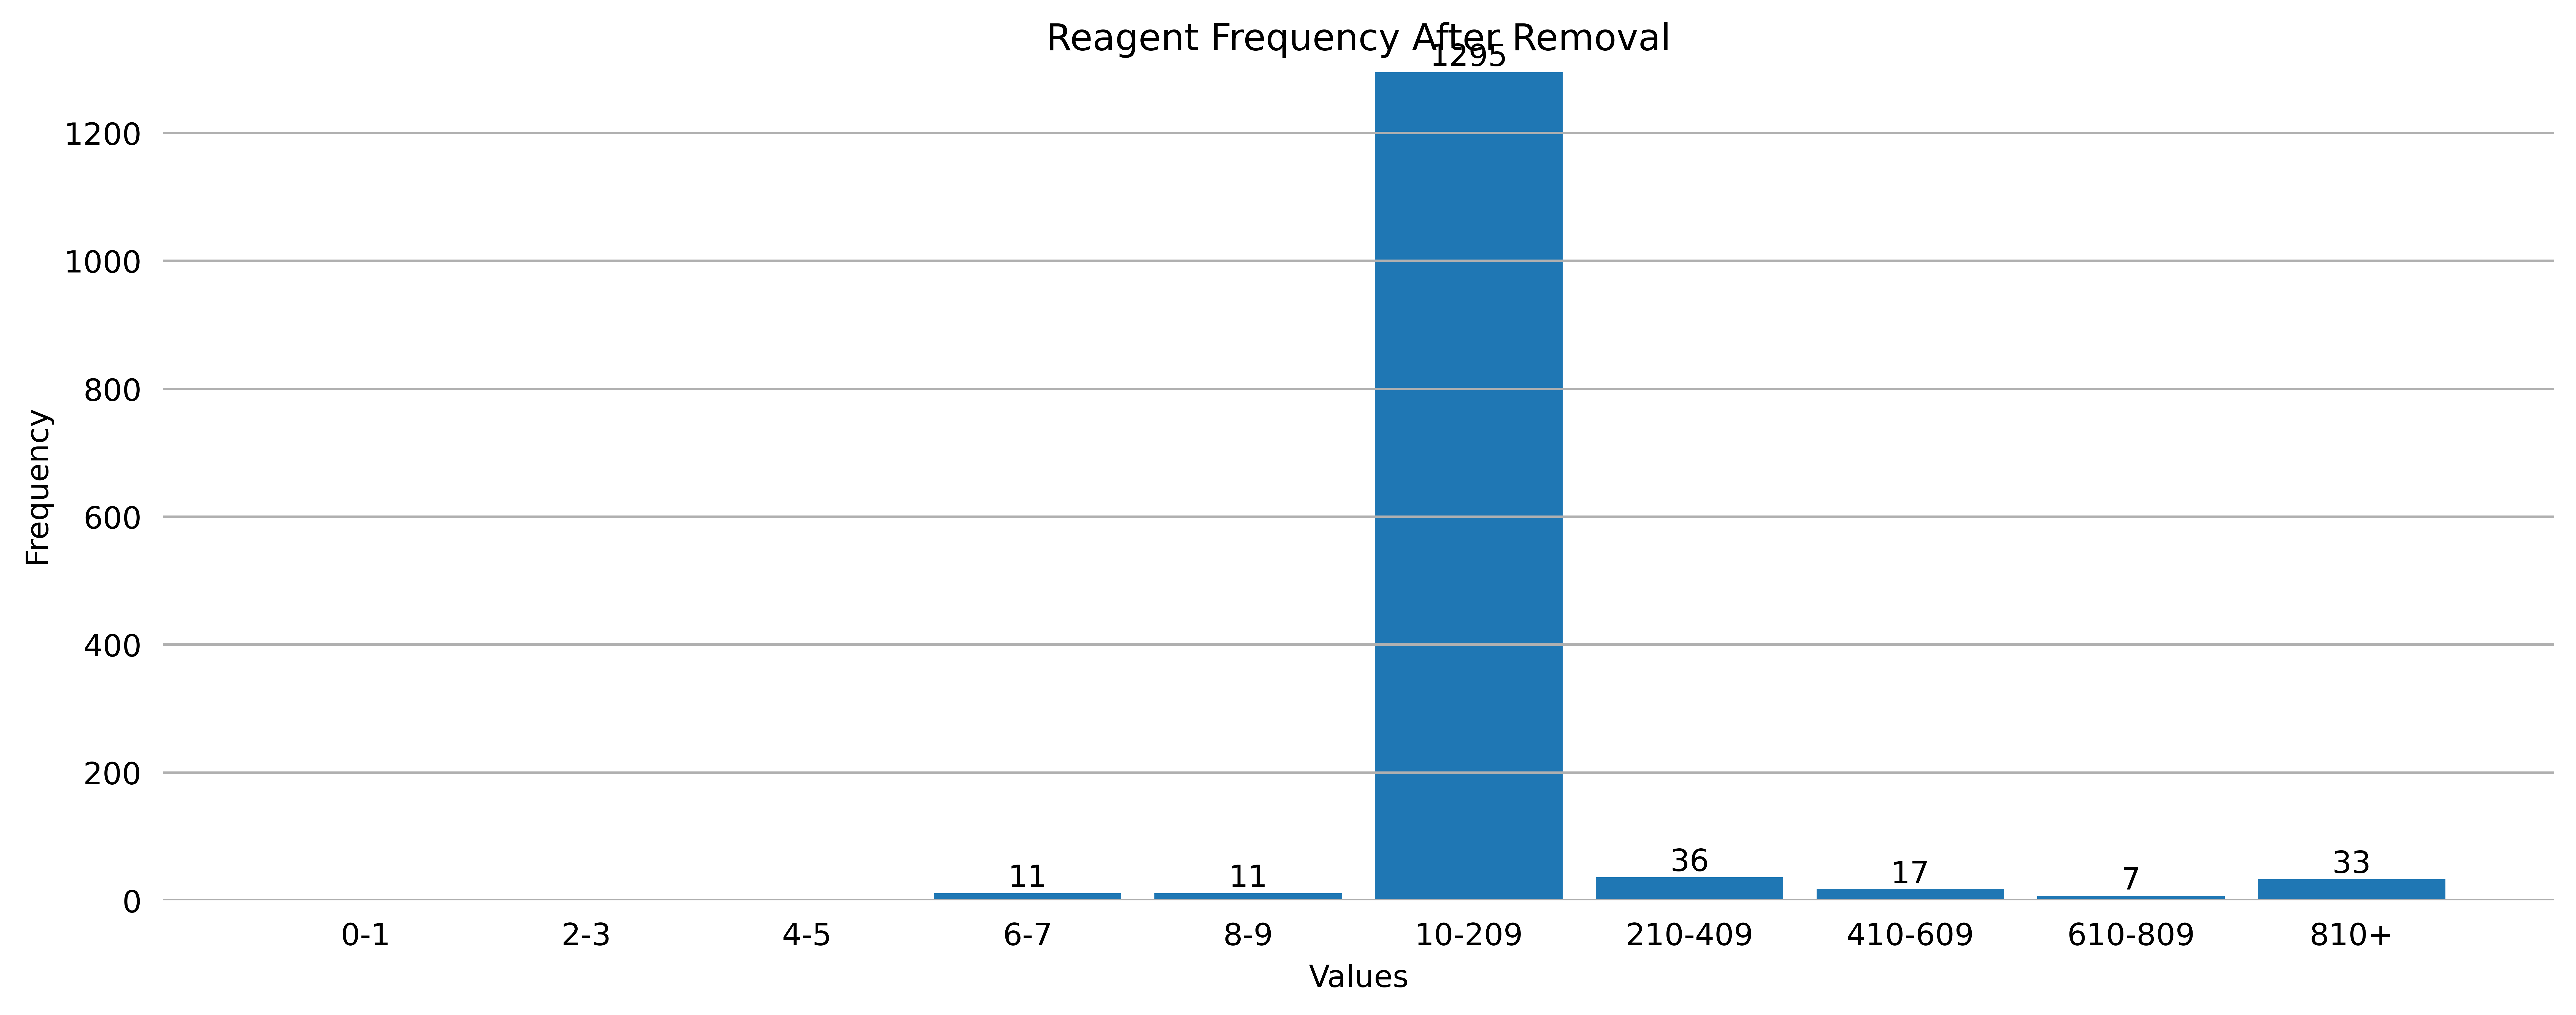

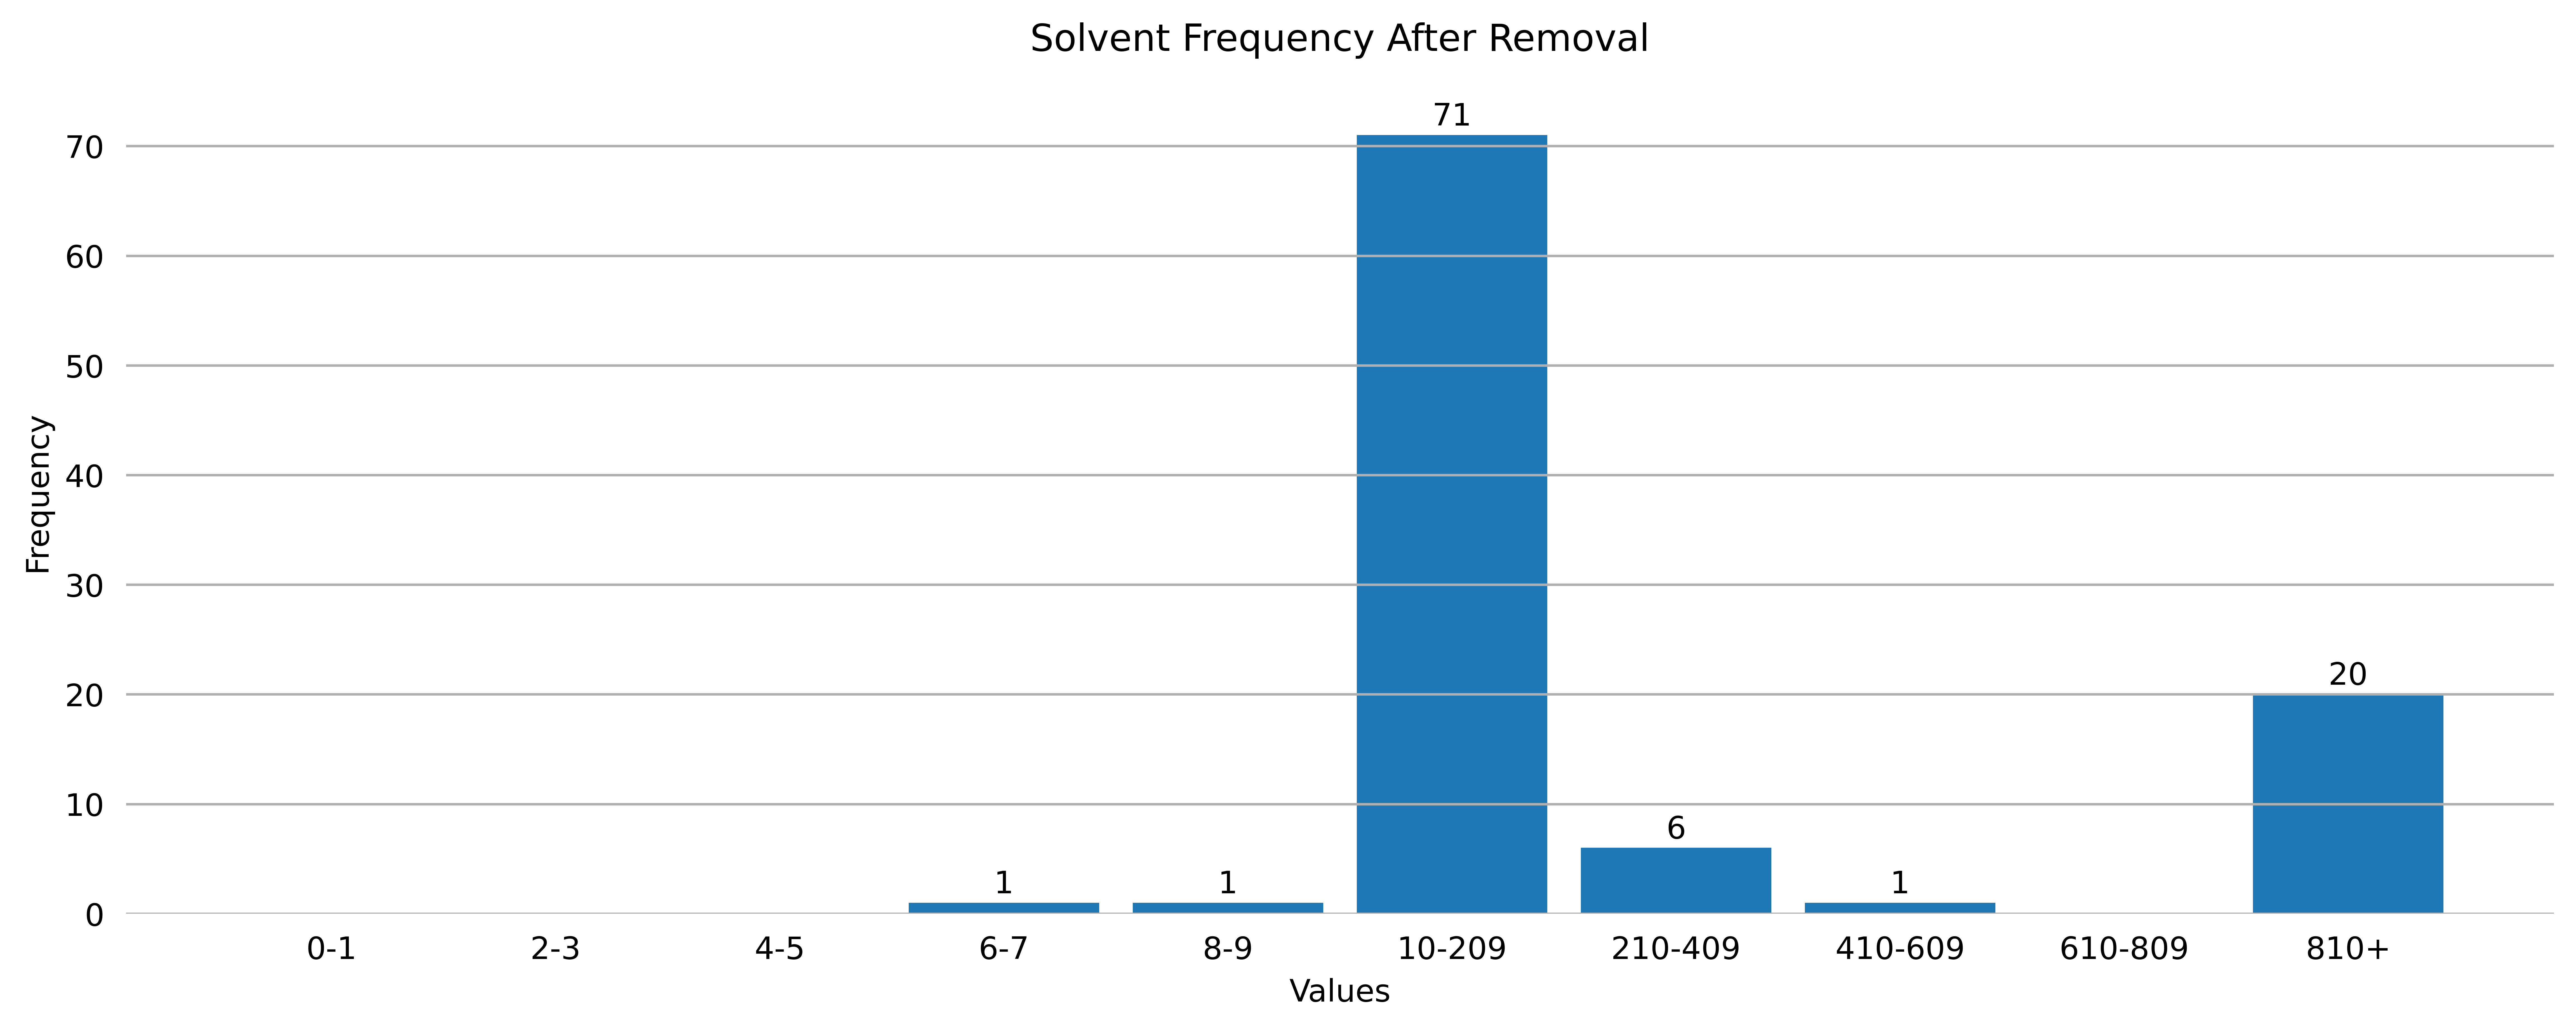

In [13]:
all_data = pd.concat(raw_datas.values())
reagent_dict = GetFrequencyDict(all_data['Reagent'])
plot_frequency(reagent_dict, 'Reagent Frequency After Removal', os.path.join(output_file_path, 'Reagent_plot_second.png'))
solvent_dict = GetFrequencyDict(all_data['Solvent (Reaction Details)'])
solvent_dict.pop('nan', None)
plot_frequency(solvent_dict, 'Solvent Frequency After Removal', os.path.join(output_file_path, 'Solvent_plot_second.png'))

print('After removing data with frequency < 10: ')
all_data.info()
print('-'*50 + '\n')
all_data.to_csv(os.path.join(output_file_path, 'processed_data.csv'))
# print('Catalyst used ratio: {:.2f}%'.format(1465/93216*100))

# Final Part: split and save the data
### (1) train, validate and test data (pd.Dataframe) -> .txt
### (2) solvent and reagent name classes (dict) -> .pkl

In [14]:
def train_validate_test_split_for_Reaxys_condition(data, train_percent=0.8, validate_percent=0.1, SEED=45):
    '''We have to split the data according to its Reaxys ID. '''
    rxn_id = list(data['Reaction ID'])
    start_ = 0
    result = []
    for i in range(len(rxn_id)):
        if rxn_id[i] != rxn_id[start_]:
            end_ = i
            result.append((start_, end_))
            start_ = end_
    result = shuffle(result, random_state=SEED)
    train_index = int(len(result)*train_percent)
    validate_index = int(len(result)*(train_percent + validate_percent))
    train_list = result[0:train_index]
    validate_list = result[train_index:validate_index]
    test_list = result[validate_index:]
    
    train_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in train_list]))
    validate_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in validate_list]))
    test_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in test_list]))
    return train_list
#     return data.loc[train_list], data.loc[validate_list], data.loc[test_list]
A = train_validate_test_split_for_Reaxys_condition(all_data)
all_data.iloc[A]

,Reaction ID,Temperature (Reaction Details) [C],Yield (numerical),Reagent,Catalyst,Solvent (Reaction Details),reactants,products
5047,8581089,65.0,55,"2,3-dicyano-5,6-dichloro-p-benzoquinone",NaN,benzene,O=C1C=CC(=O)C=C1.C=C1C(=C)[C@@]23COC4(CCCCC4)O...,C=C1C(=C)[C@]23COC4(CCCCC4)OC[C@]12C1=C3CC2=C(...
7907,23842035,20.0,18,sodium tris(acetoxy)borohydride,NaN,ethanol; dichloromethane,O=CC1=NC2=C(SCC(=O)N2)C=C1.COC1=CC=C2N=CC(F)=C...,COC1=CC=C2N=CC(F)=C(NC(=O)[C@@H]3C[C@@H](O)[C@...
6137,8964716,20.0,45.6,aluminium trichloride,NaN,dichloromethane,ClC(=O)C1=CC=CC(=C1)N(=O)=O.CCOC(=O)CCCC1=C2C=...,CCOC(=O)CCCC1=C2C=CC=CN2C(=N1)C(=O)C1=CC(=CC=C...
2975,9324014,-78.0,74,niobium pentachloride,NaN,ethyl acetate,O=C1CCCC=C1.C1C=CC=C1,[H][C@@]12CCCC(=O)[C@]1([H])C1CC2C=C1
388,41846364,100.0,83,copper(l) iodide; lithium chloride,NaN,"N,N-dimethyl-formamide",IC1=CC=C(C=C1)C#N.[Zn](C1=CC=CC=C1)C1=CC=CC=C1,N#CC1=CC=C(C=C1)C1=CC=CC=C1
...,...,...,...,...,...,...,...,...
17047,50034061,80.0,52,"palladium diacetate; caesium carbonate; 4,5-bi...",NaN,"1,4-dioxane",C[C@@H]1COCCN1C1=NC(Cl)=NC(=C1)C1(CC1)S(C)(=O)...,C[C@@H]1COCCN1C1=CC(=NC(NC2=C(F)C=CC=C2N(=O)=O...
8870,34136254,35.0,96,"1-((1S,2S)-2-aminocyclohexyl)-3-(((1R,4aS,10aR...",NaN,toluene,COC1=CC=C2N(C)C=CC2=C1.O=N(=O)C=CC1=CC=CC=C1,COC1=CC=C2N(C)C=C(C(CN(=O)=O)C3=CC=CC=C3)C2=C1...
8955,28056884,NaN,61,sodium tris(acetoxy)borohydride; sodium hydrog...,NaN,methanol,O=CC1=CN(C(=N1)C1=CC=CC=C1)S(=O)(=O)C1=CC=CS1....,OC(=O)\C=C\C(O)=O.CNCC1=CN(C(=N1)C1=CC=CC=C1)S...
6241,54976145,20.0,47.7,sodium tris(acetoxy)borohydride,NaN,"N,N-dimethyl-formamide",OC1=CC=C2C(=O)NC(C2=C1)C1=C(NC2=CC=CC=C12)C=O....,CN1C(C2=CC(O)=CC=C2C1=O)C1=C(CNCCCCCCNCC2=C(C3...


In [15]:
def train_validate_test_split_for_Reaxys_condition(data, train_percent=0.8, validate_percent=0.1, SEED=45):
    '''We have to split the data according to its Reaxys ID. '''
    rxn_id = list(data['Reaction ID'])
    start_ = 0
    result = []
    for i in range(len(rxn_id)):
        if rxn_id[i] != rxn_id[start_]:
            end_ = i
            result.append((start_, end_))
            start_ = end_
    result = shuffle(result, random_state=SEED)
    train_index = int(len(result)*train_percent)
    validate_index = int(len(result)*(train_percent + validate_percent))
    train_list = result[0:train_index]
    validate_list = result[train_index:validate_index]
    test_list = result[validate_index:]
    
    train_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in train_list]))
    validate_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in validate_list]))
    test_list = list(itertools.chain.from_iterable([list(range(a,b)) for a,b in test_list]))
    return data.iloc[train_list], data.iloc[validate_list], data.iloc[test_list]

def write_DF2text_second_part(data, output_path):
    f = open(output_path, 'w', encoding='UTF-8')
    for i in range(len(data)):
        row = data.iloc[i]
        text = str(row['Reaction ID']+'\t'+row['reactants'])+'\t'+str(row['products'])+'\t'+str(row['Yield (numerical)'])+'\t' \
        +str(row['Reagent'])+'\t'+str(row['Solvent (Reaction Details)'])+'\t'+str(row['Temperature (Reaction Details) [C]'])+'\n'
        f.write(text)
    f.close()

def write_DF2text_first_part(data, output_path):
    rxn_id = list(data['Reaction ID'])
    start_ = 0
    result = []
    for i in range(len(rxn_id)):
        if rxn_id[i] != rxn_id[start_]:
            end_ = i
            result.append((start_, end_))
            start_ = end_
    f = open(output_path, 'w', encoding='UTF-8')
    for pair in result:
        data_ = data.iloc[list(range(*pair))]
        rxn_id = str(data_['Reaction ID'][pair[0]])
        reactant = str(data_['reactants'][pair[0]])
        product = str(data_['products'][pair[0]])
        solvents = list(data_['Solvent (Reaction Details)'])
        reagents = list(data_['Reagent'])
        solvents = make_classes(solvents)
        reagents = make_classes(reagents)
        text = rxn_id+'\t'+reactant+'\t'+product+'\t'+reagents+'\t'+solvents+'\n'
        f.write(text)
    f.close()

def save_dict2pkl(Dict:dict, output_path):
    f = open(output_path, 'wb')
    pickle.dump(Dict, f)
    f.close()

def make_classes(k:list):
    a = []
    for conds in k:
        conds = str(conds) # consider the float type nan
        for cond in conds.split('; '):
            if cond not in a:
                a.append(cond)
    return '; '.join(a)

all_data = pd.concat(raw_datas.values()).reset_index(drop=True)
train_data, validate_data, test_data = train_validate_test_split_for_Reaxys_condition(all_data)

train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

output_file_path_second_part = os.path.join(output_file_path, 'For_second_part_model')
os.makedirs(output_file_path_second_part, exist_ok=True)

write_DF2text_second_part(all_data, os.path.join(output_file_path_second_part, 'Splitted_second_{}.txt'.format('total')))
write_DF2text_second_part(train_data, os.path.join(output_file_path_second_part, 'Splitted_second_{}.txt'.format('train')))
write_DF2text_second_part(validate_data, os.path.join(output_file_path_second_part, 'Splitted_second_{}.txt'.format('validate')))
write_DF2text_second_part(test_data, os.path.join(output_file_path_second_part, 'Splitted_second_{}.txt'.format('test')))

output_file_path_class = os.path.join(output_file_path, 'unprocessed_class')
os.makedirs(output_file_path_class, exist_ok=True)
save_dict2pkl(reagent_dict, os.path.join(output_file_path_class, 'class_names_{}.pkl'.format('reagent')))
save_dict2pkl(solvent_dict, os.path.join(output_file_path_class, 'class_names_{}.pkl'.format('solvent')))


In [16]:
output_file_path_first_part = os.path.join(output_file_path, 'For_first_part_model')
os.makedirs(output_file_path_first_part, exist_ok=True)

write_DF2text_first_part(all_data, os.path.join(output_file_path_first_part, 'Splitted_first_{}.txt'.format('total')))
write_DF2text_first_part(train_data, os.path.join(output_file_path_first_part, 'Splitted_first_{}.txt'.format('train')))
write_DF2text_first_part(validate_data, os.path.join(output_file_path_first_part, 'Splitted_first_{}.txt'.format('validate')))
write_DF2text_first_part(test_data, os.path.join(output_file_path_first_part, 'Splitted_first_{}.txt'.format('test')))

In [17]:
"""
Write the solvent and reagent dictionary into .txt files. => for label process
"""

f = open(os.path.join(output_file_path_class, 'class_names_reagent.txt'), 'w', encoding='UTF-8')
for key, value in reagent_dict.items():
    f.write(key + '\n')
f.close()
f = open(os.path.join(output_file_path_class, 'class_names_solvent.txt'), 'w', encoding='UTF-8')
for key, value in solvent_dict.items():
    f.write(key + '\n')
f.close()